In [11]:
import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
import visa
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
    

def adquisicion(task,time,freq):
    dt = np.divide(1,freq)
    print(dt)
    time_vector = np.arange(0,time,dt)
    print(len(time_vector))
    num_of_points = len(time_vector)  
    data = task.read(number_of_samples_per_channel=num_of_points)
    print(len(data))
    return (time_vector,np.asarray(data))


In [81]:
class adquisicion_DAQ(nidaqmx.Task,tipo='Analog'):
    def __init__(self,):
        if tipo == 'Analog':
            # Por default se abre un canal en configuracion Differential
            self.ai_channels.add_ai_voltage_chan('Dev1/ai0',
                                             terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)        
    @Feat
    def freq(self):
        return task.timing.samp_clk_rate
    @freq.setter
    def timebase(self,freq):
        # Se define una cantidad de samples de manera de poder medir 2 segundos en la frequencia definida
        task.timing.cfg_samp_clk_timing(freq,samp_per_chan=np.floor(2*freq))

    def adquisicion(self,time):
        dt = np.divide(1,self.freq)
        time_vector = np.arange(0,time,dt)
        num_of_points = len(time_vector)  
        data = self.read(number_of_samples_per_channel=num_of_points)
        return (time_vector,np.asarray(data))

        
class Generador(MessageBasedDriver):
#    def __init__(self,ID):
#        self.obj_visa=rm.open_resource(ID)
#        self.ID = ID

    # Feats punciona como un property, pero ademas acepta otras opciones
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    # La idea es no usar sets and gets como metodos, sino definir propiedades
    def setFrequency(self,freq):
        self.write("SOURce1:FREQuency:FIXed "+str(freq))
        
  #  def setAmplitude(self,amp):
  #      self.write("SOURce1:VOLTage:LEVel:IMMediate:AMPLitude "+str(amp))
    # Una manera comoda de unas Feats es con mfeats, donde directametne pasas el getter, el setter, las unidades y un limite para los valroes
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.2,5))

    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

RuntimeError: Error calling __set_name__ on 'Feat' instance 'freq' in 'adquisicion_DAQ'

In [37]:
def sweepe(generador, osciloscopio, init_freq = 100, end_freq = 10100, cant_med = 100):
    paso = np.floor(np.divide(end_freq - init_freq,cant_med))
    values = np.zeros(cant_med)
    freqs = np.add(np.multiply(np.arange(cant_med), paso), init_freq)
    magni = generador.amplitude.magnitude
    valor = np.ceil(2.0 * magni / 8.0)
    print(valor)
    osciloscopio.vertical_scale = Q_(valor,'V')
    
    for i,freq in enumerate(freqs):
        periodo = np.divide(1,freq)
        # Como en el Feats definimos las unidades, al setearlo debemos escribirlo con que unidades le estamso mandando
        osciloscopio.timebase = Q_(0.1 * periodo * 4, 's')
        # Escribir Generador
        generador.setFrequency(freq)
        # Esperamos a que se setee y lea bien
        time.sleep(1)
        # Consulta Osciloscopio
        values[i] = osci.vpp()
    return freqs, values

In [78]:
time = 0.1
freq = 5000
nsamples = 2000

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan('Dev1/ai0',
                                         terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
    task.timing.cfg_samp_clk_timing(freq,samps_per_chan=nsamples)
    (tiempos,data) = adquisicion(task,time,freq)
#    task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True)
    print(task.timing.samp_clk_rate)

0.0002
500
500
5000.0


(0, 0.1)

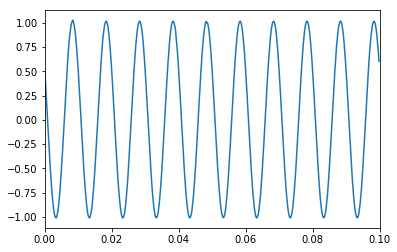

In [64]:
plt.plot(tiempos,data)  
plt.xlim(0,0.1)

In [79]:
#placa_adquisiscion = adquisicion_DAQ()
with adquisicion_DAQ() as placa:
    placa.freq = 5000
    print(placa.freq)
    
    
    

NameError: name 'adquisicion_DAQ' is not defined